## Le premier objectif du projet consiste à reproduire les principales caractéristiques du code des deux auteurs en pytorch : 

In [1]:
import os

In [2]:
train_damage_dir =  './train_another/damage'
validation_damage_dir =  './validation_another/damage'
test_damage_dir =  './test/damage'

train_nodamage_dir =  './train_another/no_damage'
validation_nodamage_dir =  './validation_another/no_damage'
test_nodamage_dir =  './test/no_damage'

In [3]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = ConvNet()


In [6]:
from torchsummary import summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [8]:
import torch
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

# Définissez la transformation des images pour les normaliser entre 0 et 1
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargez les données d'entraînement et de validation à partir des dossiers
train_dataset = torchvision.datasets.ImageFolder(root='./train_another', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_dataset = torchvision.datasets.ImageFolder(root='./validation_another', transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)


In [9]:
train_classes = len(os.listdir('./train_another'))
val_classes = len(os.listdir('./validation_another'))

print("Found {} images  belonging to {} classes.".format(len(train_dataset), train_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), val_classes))


Found 10000 images  belonging to 2 classes.
Found 21000 images  belonging to 4 classes.


In [ ]:
#pip install tqdm

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for epoch in range(30):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
        
        if i % 100 == 99: # every 100 mini-batches
            with torch.no_grad():
                val_loss = 0.0
                accuracy_val = 0
                
                start = time.perf_counter()
                for val_data in validation_loader:
                    val_inputs, val_labels = val_data
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
                    accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
                val_loss /= len(validation_loader)
                accuracy_val /= len(validation_loader)
                history['loss'].append(running_loss / 100)
                history['val_loss'].append(val_loss)
                history['acc'].append(accuracy / 100)
                history['val_acc'].append(accuracy_val)
                running_loss = 0.0
                accuracy = 0.0
    end = time.perf_counter()
    print('Epoch {}/50, 100/100 [==============================] - time: {:.4f} ms/step - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
        epoch + 1, end - start, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))



 22%|██▏       | 112/500 [03:33<12:20,  1.91s/it]  


KeyboardInterrupt: 

In [ ]:
#it is generally a good practice to save the model after training
torch.save(model.state_dict(), 'tomnod_1.pt')

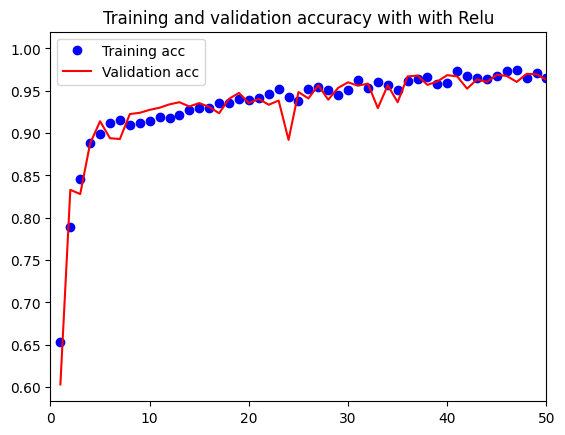

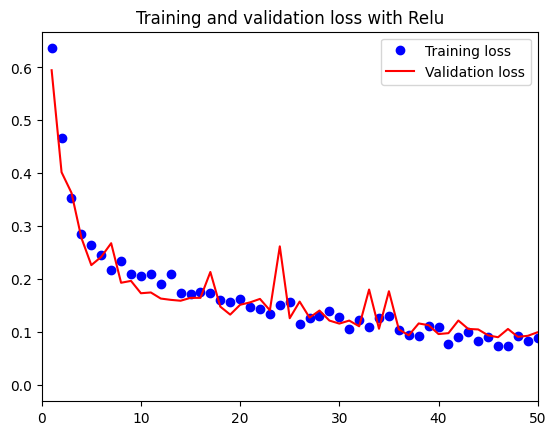

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy

plt.xlim(0, 50)
epochs = range(1, len(history['loss']) + 1)
plt.plot(epochs, history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with with Relu')
plt.legend()
plt.figure()
plt.xlim(0, 50)
plt.plot(epochs, history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss with Relu')
plt.legend()


plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        #x = x.view(-1 128 * 8 * 8)
        x = x.view(-1, 128 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
model = ConvNet()

In [ ]:
import torch
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the images

transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the training data and apply the transformations
train_dataset = torchvision.datasets.ImageFolder(root='./train_another', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the validation data and apply the transformations
val_dataset = torchvision.datasets.ImageFolder(root='./validation_another', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
train_classes = len(os.listdir('./train_another'))
val_classes = len(os.listdir('./validation_another'))

print("Found {} images  belonging to {} classes.".format(len(train_dataset), train_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), val_classes))


Found 10000 images  belonging to 2 classes.
Found 2000 images  belonging to 2 classes.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
#from tqdm import tqdm

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for epoch in range(100):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate((train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
        
        if i % 100 == 99: # every 100 mini-batches
            with torch.no_grad():
                val_loss = 0.0
                accuracy_val = 0
                
                start = time.time()
                for val_data in validation_loader:
                    val_inputs, val_labels = val_data
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
                    accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
                val_loss /= len(validation_loader)
                accuracy_val /= len(validation_loader)
                history['loss'].append(running_loss / 100)
                history['val_loss'].append(val_loss)
                history['acc'].append(accuracy / 100)
                history['val_acc'].append(accuracy_val)
                running_loss = 0.0
                accuracy = 0.0
    end = time.time()
    print('Epoch {}/100, 100/100 [==============================] - {:.4f} ms/step - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
        epoch + 1, end - start, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
            

Epoch 1/100, 100/100 [==============================] - 62.5868 ms/step - loss: 0.2045 - acc: 0.9113 - val_loss: 0.1753 - val_acc: 0.9335
Epoch 2/100, 100/100 [==============================] - 64.1625 ms/step - loss: 0.1914 - acc: 0.9237 - val_loss: 0.1531 - val_acc: 0.9415
Epoch 3/100, 100/100 [==============================] - 61.4276 ms/step - loss: 0.1714 - acc: 0.9347 - val_loss: 0.1949 - val_acc: 0.9265
Epoch 4/100, 100/100 [==============================] - 62.1226 ms/step - loss: 0.1559 - acc: 0.9384 - val_loss: 0.1333 - val_acc: 0.9475
Epoch 5/100, 100/100 [==============================] - 61.6418 ms/step - loss: 0.1443 - acc: 0.9434 - val_loss: 0.1271 - val_acc: 0.9515
Epoch 6/100, 100/100 [==============================] - 62.3171 ms/step - loss: 0.1393 - acc: 0.9475 - val_loss: 0.1297 - val_acc: 0.9505
Epoch 7/100, 100/100 [==============================] - 45.9386 ms/step - loss: 0.1211 - acc: 0.9556 - val_loss: 0.1400 - val_acc: 0.9420
Epoch 8/100, 100/100 [============

Epoch 61/100, 100/100 [==============================] - 54.9657 ms/step - loss: 0.0366 - acc: 0.9872 - val_loss: 0.0822 - val_acc: 0.9725
Epoch 62/100, 100/100 [==============================] - 54.6343 ms/step - loss: 0.0243 - acc: 0.9897 - val_loss: 0.0776 - val_acc: 0.9775
Epoch 63/100, 100/100 [==============================] - 56.5904 ms/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0777 - val_acc: 0.9750
Epoch 64/100, 100/100 [==============================] - 55.6675 ms/step - loss: 0.0199 - acc: 0.9934 - val_loss: 0.0915 - val_acc: 0.9745
Epoch 65/100, 100/100 [==============================] - 55.2940 ms/step - loss: 0.0253 - acc: 0.9912 - val_loss: 0.0727 - val_acc: 0.9775
Epoch 66/100, 100/100 [==============================] - 54.9504 ms/step - loss: 0.0299 - acc: 0.9900 - val_loss: 0.0622 - val_acc: 0.9805
Epoch 67/100, 100/100 [==============================] - 55.3774 ms/step - loss: 0.0222 - acc: 0.9922 - val_loss: 0.0659 - val_acc: 0.9795
Epoch 68/100, 100/100 [====

In [ ]:
#it is generally a good practice to save the model after training
torch.save(model.state_dict(), 'tomnod_2.pt')

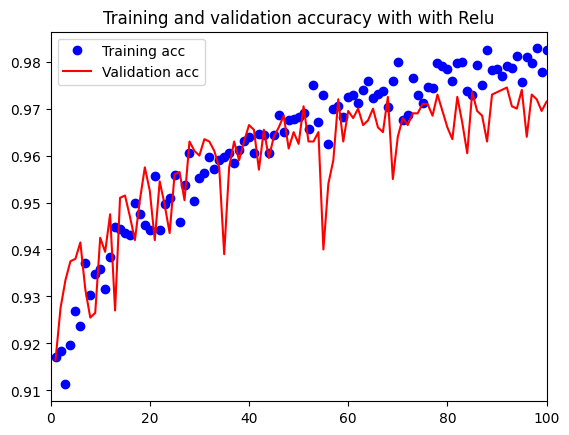

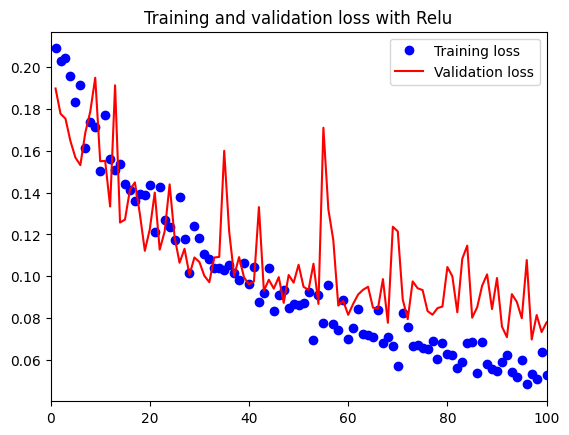

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

# Limit the x-axis to 100
x_limit = 100
if len(epochs) > x_limit:
    acc = acc[:x_limit]
    val_acc = val_acc[:x_limit]
    loss = loss[:x_limit]
    val_loss = val_loss[:x_limit]
    epochs = epochs[:x_limit]

plt.xlim(0, x_limit)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy with data aug and dropout')
plt.legend()
plt.figure()
plt.xlim(0, x_limit)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss with data aug and dropout')
plt.legend()

plt.show()



In [ ]:
#La précision de la validation peut aller jusqu'à 97%.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
model = ConvNet()

In [ ]:
import torch
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the training data and apply the transformations
train_dataset = torchvision.datasets.ImageFolder(root='./train_another', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the validation data and apply the transformations
val_dataset = torchvision.datasets.ImageFolder(root='./validation_another', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
train_classes = len(os.listdir('./train_another'))
val_classes = len(os.listdir('./validation_another'))

print("Found {} images  belonging to {} classes.".format(len(train_dataset), train_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), val_classes))

Found 10000 images  belonging to 2 classes.
Found 2000 images  belonging to 2 classes.


### Vu le temps de calcul, nous avons opté pour 10 epoch pour les autres modèles mais pour le best modèle nous lancerons les 100 epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for epoch in range(10):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate((train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
        
        if i % 100 == 99: # every 100 mini-batches
            with torch.no_grad():
                val_loss = 0.0
                accuracy_val = 0
                
                start = time.time()
                for val_data in validation_loader:
                    val_inputs, val_labels = val_data
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
                    accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
                val_loss /= len(validation_loader)
                accuracy_val /= len(validation_loader)
                history['loss'].append(running_loss / 100)
                history['val_loss'].append(val_loss)
                history['acc'].append(accuracy / 100)
                history['val_acc'].append(accuracy_val)
                running_loss = 0.0
                accuracy = 0.0
    end = time.time()
    print('Epoch {}/10, 10/10 [==============================] - {:.4f} ms/step - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
        epoch + 1, end - start, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))

Epoch 1/10, 10/10 [==============================] - 74.3887 ms/step - loss: 0.2880 - acc: 0.8897 - val_loss: 0.2521 - val_acc: 0.9010
Epoch 2/10, 10/10 [==============================] - 72.2547 ms/step - loss: 0.2365 - acc: 0.9091 - val_loss: 0.2267 - val_acc: 0.9065
Epoch 3/10, 10/10 [==============================] - 71.6478 ms/step - loss: 0.2128 - acc: 0.9197 - val_loss: 0.1979 - val_acc: 0.9185
Epoch 4/10, 10/10 [==============================] - 72.4685 ms/step - loss: 0.2039 - acc: 0.9178 - val_loss: 0.2153 - val_acc: 0.9190
Epoch 5/10, 10/10 [==============================] - 76.4197 ms/step - loss: 0.1989 - acc: 0.9237 - val_loss: 0.1968 - val_acc: 0.9260
Epoch 6/10, 10/10 [==============================] - 72.5858 ms/step - loss: 0.1866 - acc: 0.9284 - val_loss: 0.1613 - val_acc: 0.9400
Epoch 7/10, 10/10 [==============================] - 71.4295 ms/step - loss: 0.1654 - acc: 0.9378 - val_loss: 0.1478 - val_acc: 0.9445
Epoch 8/10, 10/10 [==============================] - 71

In [ ]:
#it is generally a good practice to save the model after training
torch.save(model.state_dict(), 'tomnod_33.pt')

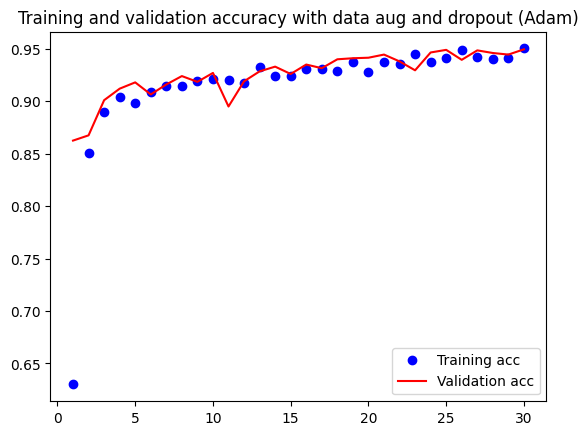

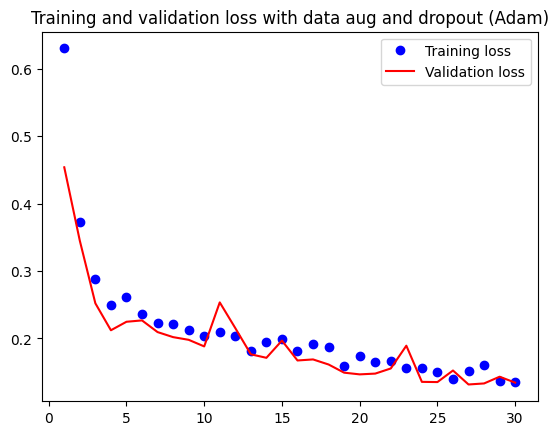

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

# Limit the x-axis to 100
#x_limit = 30
if len(epochs) > x_limit:
    acc = acc[:x_limit]
    val_acc = val_acc[:x_limit]
    loss = loss[:x_limit]
    val_loss = val_loss[:x_limit]
    epochs = epochs[:x_limit]

#plt.xlim(0, x_limit)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()
plt.figure()
#plt.xlim(0, x_limit)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()

plt.show()


In [ ]:
from torchsummary import summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 1]             513
          Sigmoid-12                    [-1, 1]               0
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
---------------------------

In [14]:
img_path ='./damage/-96.960704_28.783292.jpeg'

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

img = Image.open(img_path)
transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0)

print(img_tensor.shape)


torch.Size([1, 3, 150, 150])


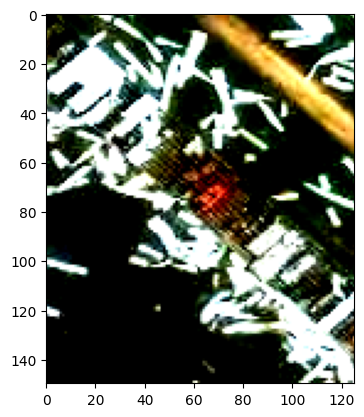

In [ ]:
img_tensor = img_tensor.clamp(0, 1)
plt.imshow(img_tensor[0].permute(1, 2, 0))
plt.xlim(0, 125)
plt.show()



Best model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32,(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.dropout5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = ConvNet()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [14]:
import torch
import torchvision
from torchvision import transforms

# Define transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=40),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

])

# Define transformation for validation data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(size=150),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load train and validation datasets
train_dataset = torchvision.datasets.ImageFolder(root='./train_another',
                                                   transform=train_transform)
validation_dataset = torchvision.datasets.ImageFolder(root='./validation_another',
                                                 transform=val_transform)

# Create data loaders for train and validation datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                         batch_size=32,
                                         shuffle=False)


In [15]:
train_classes = len(os.listdir('./train_another'))
val_classes = len(os.listdir('./validation_another'))

print("Found {} images  belonging to {} classes.".format(len(train_dataset), train_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), val_classes))

Found 10000 images  belonging to 2 classes.
Found 21000 images  belonging to 4 classes.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
#from tqdm import tqdm

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for epoch in range(10):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate((train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
        
        if i % 100 == 99: # every 100 mini-batches
            with torch.no_grad():
                val_loss = 0.0
                accuracy_val = 0
                
                start = time.time()
                for val_data in validation_loader:
                    val_inputs, val_labels = val_data
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
                    accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
                val_loss /= len(validation_loader)
                accuracy_val /= len(validation_loader)
                history['loss'].append(running_loss / 100)
                history['val_loss'].append(val_loss)
                history['acc'].append(accuracy / 100)
                history['val_acc'].append(accuracy_val)
                running_loss = 0.0
                accuracy = 0.0
    end = time.time()
    print('Epoch {}/100, 100/100 [==============================] - {:.4f} ms/step - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
        epoch + 1, end - start, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))

Epoch 1/100, 100/100 [==============================] - 137.6231 ms/step - loss: 0.4669 - acc: 0.7831 - val_loss: -0.5860 - val_acc: 0.0799
Epoch 2/100, 100/100 [==============================] - 146.9284 ms/step - loss: 0.3360 - acc: 0.8634 - val_loss: 1.5646 - val_acc: 0.0873
Epoch 3/100, 100/100 [==============================] - 146.5713 ms/step - loss: 0.3083 - acc: 0.8719 - val_loss: 1.9628 - val_acc: 0.0872
Epoch 4/100, 100/100 [==============================] - 147.8192 ms/step - loss: 0.2927 - acc: 0.8856 - val_loss: -0.2115 - val_acc: 0.0859
Epoch 5/100, 100/100 [==============================] - 128.6729 ms/step - loss: 0.2761 - acc: 0.8900 - val_loss: 2.1490 - val_acc: 0.0889


KeyboardInterrupt: 

In [ ]:
#it is generally a good practice to save the model after training
torch.save(model.state_dict(), 'tomnod_best.pt')

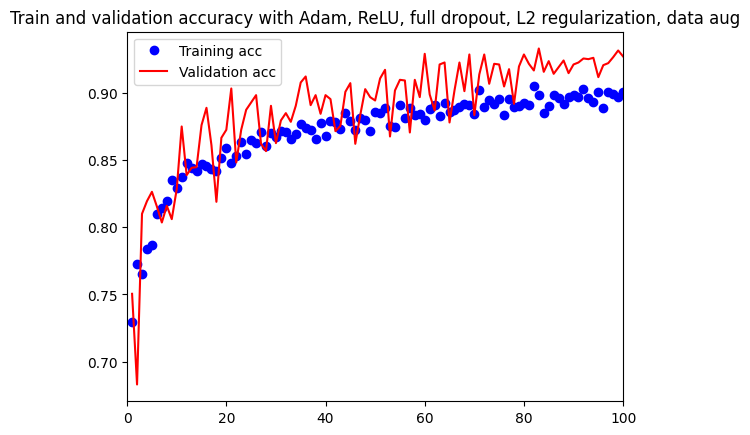

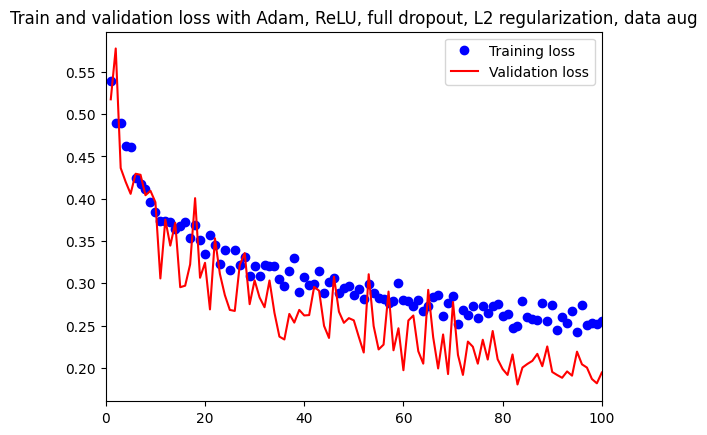

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

# Limit the x-axis to 100
x_limit = 100
if len(epochs) > x_limit:
    acc = acc[:x_limit]
    val_acc = val_acc[:x_limit]
    loss = loss[:x_limit]
    val_loss = val_loss[:x_limit]
    epochs = epochs[:x_limit]

plt.xlim(0, x_limit)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Train and validation accuracy with Adam, ReLU, 50"%" dropout, data aug')
plt.legend()
plt.figure()
plt.xlim(0, x_limit)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and validation loss with Adam, ReLU, 50"%" dropout, data aug')
plt.legend()

plt.show()

In [ ]:
from torchsummary import summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
         Dropout2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
         MaxPool2d-5           [-1, 64, 36, 36]               0
         Dropout2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
         MaxPool2d-8          [-1, 128, 17, 17]               0
         Dropout2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
        MaxPool2d-11            [-1, 128, 7, 7]               0
        Dropout2d-12            [-1, 128, 7, 7]               0
           Linear-13                  [-1, 512]       3,211,776
          Dropout-14                  [

# Transfer Learning

## VGG16

In [19]:
#TRANSFER LEARNING
#The authors did : using feature extraction from ImageNet VGG16 - library : keras
#We do : using feature extraction from ImageNet VGG16 - library : pytorch
import torch
import torch.nn as nn
import torchvision.models as models

import torch.cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = models.vgg16(pretrained=True) # pre-trained model
conv_base = conv_base.to(device)
conv_base = torch.nn.Sequential(*list(conv_base.children())[:-2]) # remove the last layer

from torchsummary import summary
summary(conv_base, (3, 150, 150)) #same input shape #3 for RGB 150 x 150 pixels


#summary check : ok
#Total params: 14,714,688
#Trainable params: 14,714,688
#Non-trainable params: 0
#max Pool 2D : same layer, ok

/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/pierre/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [20]:
#Method 1: Fast feature extraction without data augmentation
#Run the conv_base on the dataset and save as Numpy array on disk
#Then build the dense layer on this
#This is faster to run, but we cannot augment the data

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_dir = "./train_another"
validation_dir = "./validation_another"
test_dir = "./test"
#transform
data_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [21]:
#define extract_features
#generators yield data indefinitely
#have to break after we have seen every image once
#try parallized (cuda)

import torch.cuda

def extract_features(dataloader, sample_count):
    batch_size = dataloader.batch_size
    features = torch.zeros(size=(sample_count, 4, 4, 512), dtype=torch.float32).to(device)
    labels = torch.zeros(size=(sample_count,1), dtype=torch.float32).to(device)
    
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(dataloader):
            inputs_batch = inputs_batch.to(device)
            features_batch = conv_base(inputs_batch).view(inputs_batch.size(0), 4,4,512)
            features[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = features_batch
            labels_batch = labels_batch.view(-1, 1)
            labels[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = labels_batch.to(device)
            if i * batch_size >= sample_count:
                break
        return features, labels

In [27]:
# extraction
# Check if CUDA is available and move the features and labels to the GPU
train_features, train_labels = extract_features(train_loader, 10000)
# if torch.cuda.is_available():
#     train_features = train_features.cuda()
#     train_labels = train_labels.cuda()

validation_features, validation_labels = extract_features(validation_loader, 2000)
# if torch.cuda.is_available():
#     val_features = validation_features.cuda()
#     validation_labels = validation_labels.cuda()

test_features, test_labels = extract_features(test_loader, 2000)
# if torch.cuda.is_available():
#     test_features = test_features.cuda()
#     test_labels = test_labels.cuda()

KeyboardInterrupt: 

In [24]:
#flatten steps
train_features = train_features.reshape(10000, 512*4*4)
validation_features = validation_features.reshape(2000, 512*4*4)
test_features = test_features.reshape(2000, 512*4*4)

NameError: name 'train_features' is not defined

In [ ]:
#define the densely connected layer
#import Optimizers
import torch.optim as optim


class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.conv_base = conv_base #to initialize the connection with the pre-trained model (whose dense layers were removed)
        self.fc1 = nn.Linear(512*4*4, 8192) #input_size (#256,1 defined per default as per see below)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(8192,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.shape[0], -1) # to reshape the inputs into 1 dimension, #x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x
model = DenseNet()

In [ ]:
#Check whether customized dense layers are correctly connected to VGG16
from torchsummary import summary
print(model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Define the loss function and the optimizer, with the same parameters as the scientists implemented

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss() #Binary cross-entrpoy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) 


for epoch in range(10):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        labels=labels.view(-1,1)
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().sum().item()) / len(labels)

    with torch.no_grad():
        val_loss = 0.0
        accuracy_val = 0

        start = time.perf_counter()
        for val_data in validation_loader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().item())
            accuracy_val += (torch.round(val_outputs) == val_labels.float().sum().item()) / len(val_labels)
        val_loss /= len(validation_loader)
        accuracy_val /= len(validation_loader)
        history['loss'].append(running_loss / 100)
        history['val_loss'].append(val_loss)
        history['acc'].append(accuracy / 100)
        history['val_acc'].append(accuracy_val)
        running_loss = 0.0
        accuracy = 0.0
        if i % 20 == 0: # Only print every 20 iterations
            print('Epoch {}/30, 500/500 [==============================] - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
                epoch + 1, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
end = time.perf_counter()

In [ ]:
#save the model with pretrained features in Numpy array (no data augmentation)
torch.save(model.state_dict(), 'tomnod_transfer_VGG16.pt')

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy


plt.plot(epoch, history['acc'], 'bo', label='Training acc')
plt.plot(epoch, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with pre-trained features')
plt.legend()
plt.figure()
epochs = range(1, len(history['loss']) + 1)
plt.plot(epoch, history['loss'], 'bo', label='Training loss')
plt.plot(epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation accuracy with pre-trained features')
plt.legend()


plt.show()

## VGG16 type B

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch.cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = models.vgg16(pretrained=True) # pre-trained model
conv_base = conv_base.to(device)
conv_base = torch.nn.Sequential(*list(conv_base.children())[:-2]) # remove the last layer

from torchsummary import summary
summary(conv_base, (3, 150, 150))

/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [29]:

#data augmentation with the same parameters used by the scientists
#freeze the paramters of the pre-trained network

for param in conv_base.parameters():
    param.requires_grad = False # les gradients ne seront pas calculés lors de la phse d'entaînement pour ces paramtères


# Add custom fully connected layers
class CustomClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_base = conv_base
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*4*512, 256) #25088, poids de la dernière couche
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CustomClassifier().to(device)

In [30]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns

#data augmentation   
train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(1, 1), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

train_dataset = datasets.ImageFolder(root='./train_another', transform=train_datagen)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_dataset = datasets.ImageFolder(root='./validation_another', transform=val_datagen)
validation_dataloader = DataLoader(validation_dataset, batch_size=20, shuffle=True)    

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Define the loss function and the optimizer, with the same parameters as the scientists implemented

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss() #Binary cross-entrpoy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) 

for epoch in range(30):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)

    with torch.no_grad():
        val_loss = 0.0
        accuracy_val = 0

        start = time.perf_counter()
        for val_data in validation_dataloader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
            accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
        val_loss /= len(validation_loader)
        accuracy_val /= len(validation_loader)
        history['loss'].append(running_loss / 100)
        history['val_loss'].append(val_loss)
        history['acc'].append(accuracy / 100)
        history['val_acc'].append(accuracy_val)
        running_loss = 0.0
        accuracy = 0.0
        if i % 20 == 0: # Only print every 20 iterations
            print('Epoch {}/30, 500/500 [==============================] - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
                epoch + 1, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
end = time.perf_counter()

100%|██████████| 500/500 [12:13<00:00,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
#save the model with transfer learning and data augmentation
torch.save(model.state_dict(), 'tomnod_transfer_dataAugment.pt')

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy


plt.plot(epoch, history['acc'], 'bo', label='Training acc')
plt.plot(epoch, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()
plt.figure()
epoch = range(1, len(history['loss']) + 1)
plt.plot(epoch, history['loss'], 'bo', label='Training loss')
plt.plot(epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()


plt.show()